# SpicyBot
### Twitter Sentiment Analysis

This bot will scan for tweets to it asking for analysis of a Twitter account. The bot will then check to see if the requested account for analysis has already been analyzed. If so, it will respond that the account has already been analyzed. If not, the bot will pull the last 500 tweets and analyze them for positive or nagative sentiment, and then plot and tweet out the plot of the results.

looking for tweets
@spicy_michelada Analyze: @paulkrugman
searching to see if the user has been analyzed
we just tried to do a repeat tweet
appending the user to the list and getting 500 tweets


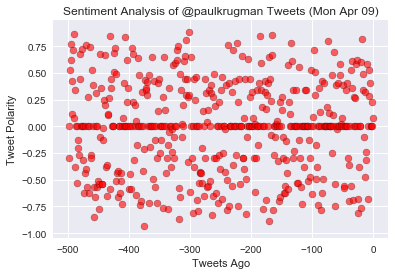

we got blocked from sending out an automated tweet.
waiting 5 minutes


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
import pandas as pd
import time

from config import (
    consumer_key,
    consumer_secret,
    access_token,
    access_token_secret
    )

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

#initial variables
search_id = 0
botname = '@Spicy_Michelada'
previous_analysis = []
running = 0
n_tweets = 500



while running == 0:
    #set some initial local variables
    search_name = ''
    already_searched = False
    text_list = []
    
    #do a search (we're going to search for only the most recent item)
    print('looking for tweets')
    tweet_search = api.search(q=botname, since_id=search_id, parser=tweepy.parsers.JSONParser(), 
                                  count=1)
    try:
        search_id = tweet_search['statuses'][0]['id']
        tweet_text = tweet_search['statuses'][0]['text']
        text_list = tweet_text.split()
        print(tweet_text)
    except:
        print("we didn't have needed info in that tweet.")
    
    if text_list[1] == 'Analyze:':
        search_name = text_list[2]
        print_name = search_name[1:]
            #get the date of the tweet request to use for later in the plot title
        try:
            date = tweet_search['statuses'][0]['created_at']
            date = date.split()
            request_date = date[:3]
        except:
            print('no tweet to get date from.')

#check to see if that account has been analyzed before - tweet either "analyzing" or "sorry, we've already
#done an analysis on that account"

    if search_name[0] == '@':
        print('searching to see if the user has been analyzed')
        for user in previous_analysis:
            if user == search_name:
                print('Sorry, that account has already been analyzed.')
                api.update_status('Sorry, that account has already been analyzed.')
                already_searched = True

        
#pull 500 tweets from the account and use Vader to analyze while looping through them.
#create a list with "tweets ago" which can be just x from each loop - subtracting 1 for each loop.    
    
        if already_searched == False:
            try:
                api.update_status(f'Hold on while we perform an analysis of the account {print_name}.')
                print('Hold on while we perform an analysis of that account.')
            except:
                print('we just tried to do a repeat tweet, or are currently blocked.')
            previous_analysis.append(search_name)
            tweets_ago_list = []
            compound_list = []
            print('appending the user to the list and getting 500 tweets')
            
            x = 0

            for status in tweepy.Cursor(api.user_timeline, id=search_name).items(n_tweets):
                tweet = status._json
                tweets_ago = x
                x = x-1
                results = analyzer.polarity_scores(tweet["text"])
                compound = results["compound"]
                compound_list.append(compound)
                tweets_ago_list.append(tweets_ago)

            df = pd.DataFrame({
                'Tweet Polarity': compound_list,
                'Tweets Ago': tweets_ago_list
                })   
            df = df.sort_values(by='Tweets Ago', ascending=True)


#graph the results and format the graph with the date pulled (which is the current date - we should be able to get the date
#from the request tweet asking for analysis)
#include the name of the analyzed account in the graph as part of the title (use a f string f"string text {variable})
            sns.set()
            fig = plt.figure()
            plt.scatter(x=df['Tweets Ago'], y=df['Tweet Polarity'], facecolor='red', color='k', alpha=0.6)
            plt.title(f'Sentiment Analysis of {search_name} Tweets ({request_date[0]} {request_date[1]} {request_date[2]})')
            #note: I'm using the request date for the date because when the bot is running it will operate on recent requests only.
            plt.xlabel('Tweets Ago')
            plt.ylabel('Tweet Polarity')
            plt.show()

            figname = f'plot_{search_name}.png'

            fig.savefig(figname)


#tweet out the resultant graph
            try:
                api.update_with_media(figname, status=f"Here is the completed analysis for {print_name}.")
                print('tweeting out the result')
            except:
                print('we got blocked from sending out an automated tweet.')
    
    print('waiting 5 minutes')
    time.sleep(300)

